# 생존자(Survived) 예측 모델 만들기
* ./data/titanic.csv 를 이용
* 데이터셋 8:2 split (train: 80%, test: 20%)
* random_state=3333 고정
* PassengerId : 인덱스
* Survived : 생존여부 (0: 사망, 1: 생존) -> 타겟컬럼
* Pclass : 티켓 등급 (1: 1등석, 2: 2등석, 3: 3등석)
* Name : 승객 이름 --> 결혼여부
* Sex : 성별
* Age : 나이
* SibSp : 함께 탑승한 형제자매, 배우자 수
* Parch : 함께 탑승한 부모, 자식 수
* Ticket : 티켓 번호 
* Fare : 티켓 요금
* Cabin : 객실 번호
* Embarked : 탑승한 항구 (C: Cherbourg, Q: Queenstown, S: Southampton)

- EDA : ?
- 전처리
- 모델링
- 하이퍼파라미터 튜닝
- 평가
- Survived 예측하기
- 내일 아침 09:05까지 최고점수 제출

In [ ]:
# 생존자(Survived) 예측 모델 만들기
# ./data/titanic.csv 를 이용
# 데이터셋 8:2 split (train: 80%, test: 20%)
# random_state=3333 고정
# PassengerId : 인덱스
# Survived : 생존여부 (0: 사망, 1: 생존) -> 타겟컬럼
# Pclass : 티켓 등급 (1: 1등석, 2: 2등석, 3: 3등석)
# Name : 승객 이름 --> 결혼여부
# Sex : 성별
# Age : 나이
# SibSp : 함께 탑승한 형제자매, 배우자 수
# Parch : 함께 탑승한 부모, 자식 수
# Ticket : 티켓 번호 
# Fare : 티켓 요금
# Cabin : 객실 번호
# Embarked : 탑승한 항구 (C: Cherbourg, Q: Queenstown, S: Southampton)

# EDA : 
# 전처리
# 모델링
# 하이퍼파라미터 튜닝
# 평가
# Survived 예측하기
# 내일 아침 09:05까지 최고점수 제출

## 이상치를 확인해야 함 : fare 등
## 데이터 스케일링을 해야 함
## 옵투나?

In [1]:
print("hello world") # 커널이 죽었는지 확인

hello world


In [2]:
# csv 파일 불러오기
import pandas as pd
data = pd.read_csv('./data/titanic.csv')
data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# 데이터 전처리
data = data.set_index('PassengerId') # PassengerId를 인덱스로 설정
data['Name_length'] = data['Name'].apply(len) # Name 길이 컬럼 추가
data['Is_Married'] = data['Name'].apply(lambda x: 1 if 'Mrs.' in x else 0) # 결혼여부 컬럼 추가
data['Has_Cabin'] = data['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1) # 객실 정보 유무 컬럼 추가
data['Age'] = data['Age'].fillna(data['Age'].median()) # Age 결측치 중앙값으로 대체
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0]) # Embarked 결측치 최빈값으로 대체
data = pd.get_dummies(data, columns=['Sex', 'Embarked'], drop_first=True) # 범주형 변수 원-핫 인코딩
data['Family_Size'] = data['SibSp'] + data['Parch'] + 1 # 가족 크기 컬럼 추가
data['is_Alone'] = data['Family_Size'].apply(lambda x: 1 if x == 1 else 0) # 혼자 탑승 여부 컬럼 추가
data['F_name'] = data['Name'].apply(lambda x: x.split(',')[0]).apply(len) # 성씨 컬럼 추가

data = data.drop(columns=['Name', 'Ticket', 'Cabin']) # 불필요한 컬럼 제거

data.head()



,Survived,Pclass,Age,SibSp,Parch,Fare,Name_length,Is_Married,Has_Cabin,Sex_male,Embarked_Q,Embarked_S,Family_Size,is_Alone,F_name
PassengerId,,,,,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,23,0,0,True,False,True,2,0,6
2,1,1,38.0,1,0,71.2833,51,1,1,False,False,False,2,0,7
3,1,3,26.0,0,0,7.9250,22,0,0,False,False,True,1,1,9
4,1,1,35.0,1,0,53.1000,44,1,1,False,False,True,2,0,8
5,0,3,35.0,0,0,8.0500,24,0,0,True,False,True,1,1,5


In [4]:
# 데이터셋 8:2 split (train: 80%, test: 20%)
from sklearn.model_selection import train_test_split
X = data.drop(columns=['Survived'])
y = data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3333)
X_train.head()


,Pclass,Age,SibSp,Parch,Fare,Name_length,Is_Married,Has_Cabin,Sex_male,Embarked_Q,Embarked_S,Family_Size,is_Alone,F_name
PassengerId,,,,,,,,,,,,,,
160,3,28.0,8,2,69.5500,26,0,0,True,False,True,11,0,4
15,3,14.0,0,0,7.8542,36,0,0,False,False,True,1,1,7
351,3,23.0,0,0,9.2250,22,0,0,True,False,True,1,1,5
714,3,29.0,0,0,9.4833,26,0,0,True,False,True,1,1,7
754,3,23.0,0,0,7.8958,18,0,0,True,False,True,1,1,7


In [5]:
# 모델링
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=3333)
model.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [6]:
# 평가
from sklearn.metrics import accuracy_score, classification_report
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8268156424581006
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.90      0.85       101
           1       0.85      0.73      0.79        78

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.82       179



In [7]:
# hyperparameter tuning
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [1, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 16, 20, 30, 40, 50, 70, 90, 100, 200, 300],
    'max_depth': [1, 3, 5, 6, 7, 8, 9, 10, 12, 14, 20],
    'min_samples_split': [2, 5, 10]
}

In [8]:
estimator = RandomForestClassifier(random_state=3333)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
# print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Score: 0.8440756426671919


<Axes: >

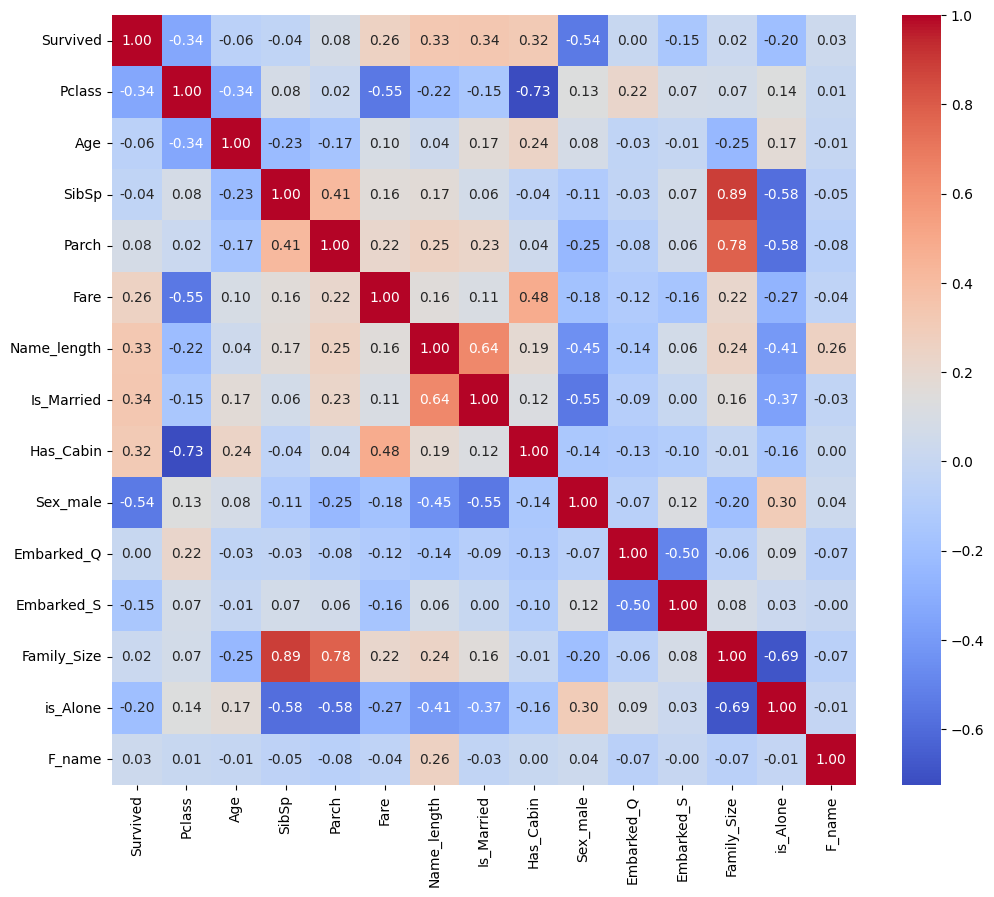

In [9]:
# 상관분석
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 10))
corr = data.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')

In [10]:
# 상관분석 변인 top 10
corr_target = abs(corr['Survived'])
top_features = corr_target.sort_values(ascending=False).head(10)
print(top_features)

Survived       1.000000
Sex_male       0.543351
Is_Married     0.339040
Pclass         0.338481
Name_length    0.332350
Has_Cabin      0.316912
Fare           0.257307
is_Alone       0.203367
Embarked_S     0.149683
Parch          0.081629
Name: Survived, dtype: float64


In [11]:
# using XGBoost
import xgboost as xgb

estimator = xgb.XGBClassifier(random_state=3333, eval_metric='logloss')

# min_samples_split 는 XGBoost에 없는 파라미터이므로 제거
param_grid_xgb = {
    'n_estimators': [1, 3, 4, 5, 6, 7, 10, 20, 30, 40, 50, 70, 90, 100, 200, 300],
    'max_depth': [1, 3, 5, 6, 7, 8, 9, 10, 20]
}

grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid_xgb, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 7, 'n_estimators': 5}
Best Score: 0.8341967891263666


In [12]:
# apply SVM
from sklearn.svm import SVC
svm_model = SVC(random_state=3333)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.6927374301675978
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.93      0.77       101
           1       0.81      0.38      0.52        78

    accuracy                           0.69       179
   macro avg       0.74      0.66      0.65       179
weighted avg       0.73      0.69      0.66       179

